# Star 69

###  Draft RPGF3 List ✨

In [1]:
from collections import defaultdict
from datetime import datetime, timedelta, timezone
import json
import pandas as pd

from scripts.oso_db import execute_query
from scripts.eas_lists import OsoData, listify, create_eas_json

# Prep

In [2]:
# settings

DATA_DIR  = "data/RPGF3/"
DATA_PATH = DATA_DIR + "2023-10-31_RPGF3_cleaned_applicant_data.json"

LIST_NAME = "Star69"
LINK_BASE = "https://github.com/opensource-observer/insights/blob/main/notebooks/"
FILENAME  = "2023-10-29_ListStar69.ipynb"
LIST_LINK = LINK_BASE + FILENAME

LIST_DESC = " ".join([
                "This list only considers projects with open source GitHub repos that have received more",
                "than 69 stars. The list identifies when the project received its 69th star and allocates",
                "OP Tokens based on how many days it's been since then. In other words, it favors popular,",
                "older OSS projects over newer and/or less popular OSS projects."
            ])
LIST_CATS = [
            #'COLLECTIVE_GOVERNANCE',
            'DEVELOPER_ECOSYSTEM', 
            'END_USER_EXPERIENCE_AND_ADOPTION', 
            'OP_STACK'
            ]

AWARD_AMT = 100000000

JSON_PATH = DATA_DIR + LIST_NAME + ".json"

In [3]:
# ingest data

oso = OsoData(DATA_PATH)
slugs = oso.get_project_slugs()
slugs_to_ids = oso.map_slugs_to_ids()
print()

oso.check_duplicate_slugs()

Loaded 360 OSS projects from data/RPGF3/2023-10-31_RPGF3_cleaned_applicant_data.json.
Identified 336 unique slugs.



,Project Name,Slug: Primary,Payout Address
85,Abhinav,awesome-optimism-lucas-op,0x23583685Ff8d24cD53B9809D2686fB03746E069e
217,Awesome Optimism,awesome-optimism-lucas-op,0x82aCDE34C057B009041B030f34F03a11f50735bf
340,Bankless DAO,banklessdao,0x918cEB96DeEaBa2Db06b18d7FC8F52FE0a206040
285,jengajojo,banklessdao,0x918ceb96deeaba2db06b18d7fc8f52fe0a206040
330,International Media Nodes (IMN),banklessdao,0x918cEB96DeEaBa2Db06b18d7FC8F52FE0a206040
121,ERC1155 Bridge,bootnodedev,0x6b10D7Fc3774431aDD486265a9049e4c9b7eFE5B
152,Bedrock Contracts Architecture Diagram,bootnodedev,0x6b10D7Fc3774431aDD486265a9049e4c9b7eFE5B
251,Randomness Ceremony,filosofiacodigo,0xFe568475CFc25563B5A5E9769f56b61dF85e7Dec
134,FilosofiaCodigo,filosofiacodigo,0xb6F5414bAb8d5ad8F33E37591C02f7284E974FcB
153,Gitcoin Passport,gitcoin,0x16883ef6737bd243BB638Bd09b0C31c47F34D258


# Get the data to power the list

In [4]:
# run query (may take a few minutes)

slugs_list = "','".join(slugs)
stopper = 69
query = f"""
    WITH RankedEvents AS (
        SELECT
            e.time,
            p.slug,
            ROW_NUMBER() OVER (PARTITION BY p.slug ORDER BY e.time) AS row_num
        FROM
            event e
        LEFT JOIN
            project_artifacts_artifact paa ON e."toId" = paa."artifactId"
        LEFT JOIN
            project p ON paa."projectId" = p."id"
        WHERE
            p.slug IN ('{slugs_list}')
            AND e."typeId" = 21
    )
    SELECT
        time,
        slug
    FROM
        RankedEvents
    WHERE
        row_num <= {stopper}
    ORDER BY
        slug,
        time;
"""
results = execute_query(query, col_names=False)

In [5]:
# transform query results

project_dates = defaultdict(list)

for date_str, project in results:
    project_dates[project].append(date_str)

project_ages = {}

for project, dates in project_dates.items():
    if len(dates) >= stopper:
        project_ages[project] = (datetime.now().timestamp() - dates[stopper-1].timestamp()) / (60*60*24)
    else:
        project_ages[project] = 0

# Generate the list

In [6]:
named_list = listify(project_ages, AWARD_AMT)
rpgf_list = {slugs_to_ids[k]:v for k,v in named_list.items()}

<AxesSubplot:>

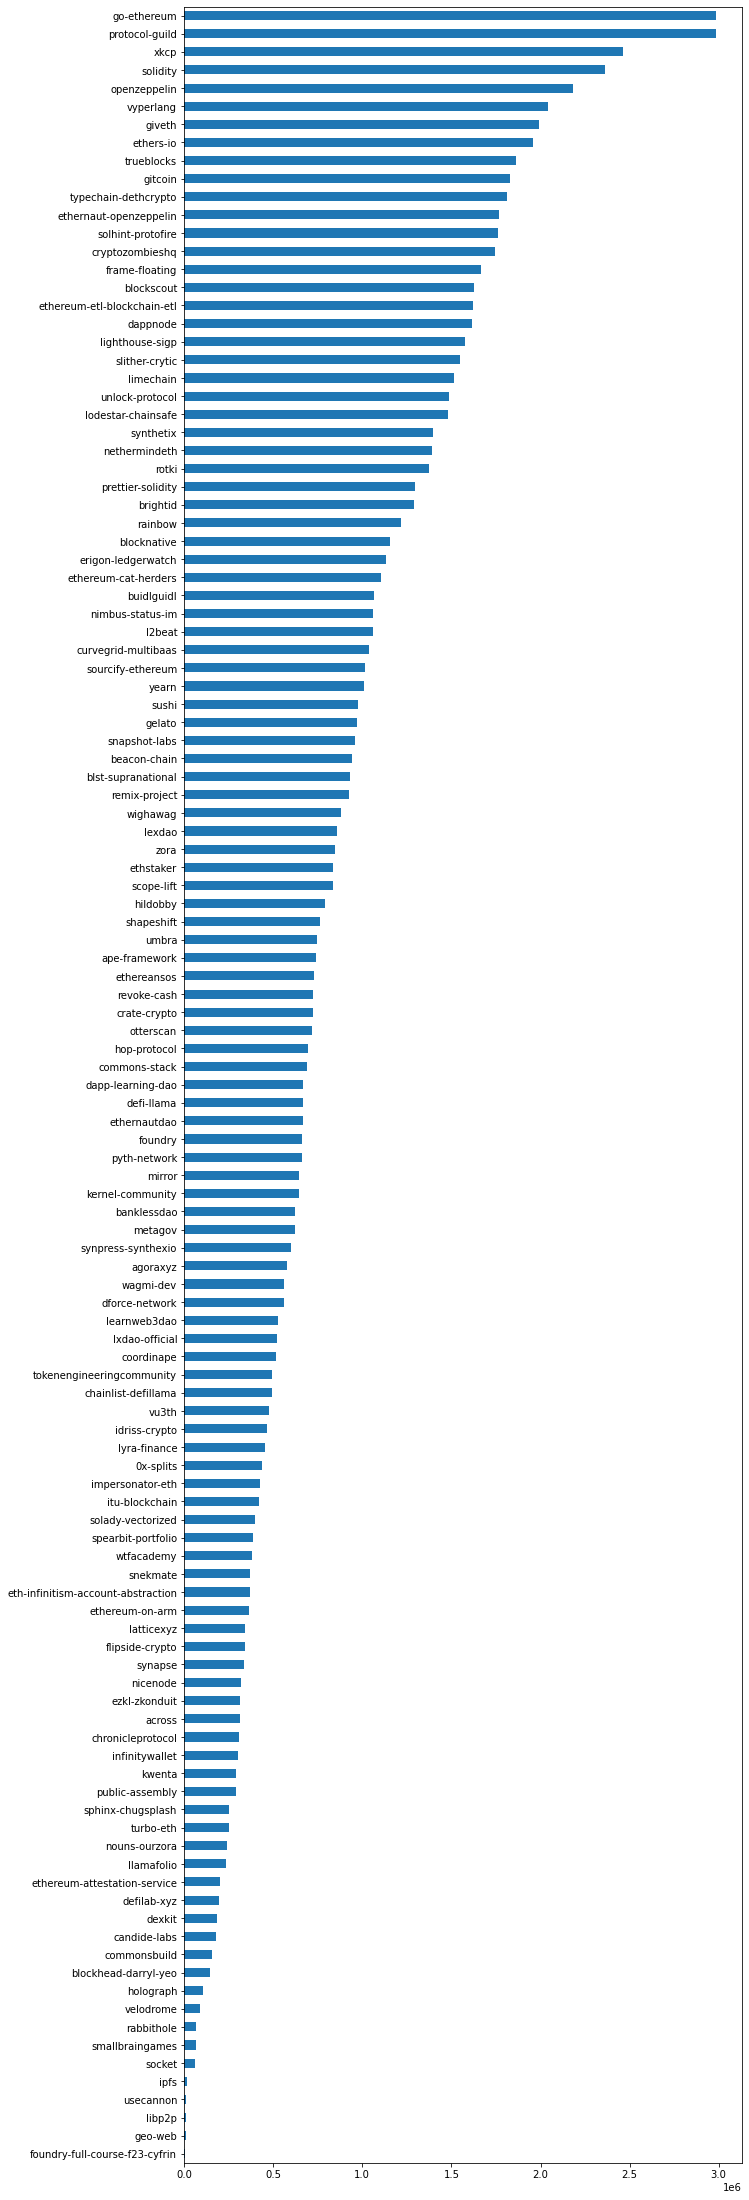

In [7]:
series = pd.Series(named_list).sort_values()
series = series[series>0]
series.plot(kind='barh', figsize=(10,len(rpgf_list)/3))

In [8]:
eas_metadata = create_eas_json(rpgf_list, LIST_NAME, LIST_LINK, LIST_DESC, LIST_CATS)

In [9]:
with open(JSON_PATH, "w") as f:
    json.dump(eas_metadata, f, indent=4)